In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs682/assignments/assignment3/'
FOLDERNAME = 'final_project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/Sharedrives/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
from torch.autograd import Variable

###Data Processing

##Load CSV Files

In [ ]:
#   Return Vlue Dimension: X_3[i]=ith music, X_3[i][j]=jth segment in ith music, X_3[i][j][k]=kth feature of jth segment in ith music
#                          X_30[i]=ith music, X_30[i][j] = jth feature in ith music
def load_csv():
  X_30 = pd.read_csv('/content/drive/Shareddrives/final_project/datasets/features_30_sec.csv', header=0)
  X_3_tmp = pd.read_csv('/content/drive/Shareddrives/final_project/datasets/features_3_sec.csv', header=0)
  X_3_tmp = np.array(X_3_tmp)

  X_3 = []
  cur = []

  i = 0
  while i < X_3_tmp.shape[0]:
    if X_3_tmp[i][0][-5] == "9":
      i+=1
      continue
    cur.append(X_3_tmp[i])
    i+=1

  X_3_tmp = np.array(cur)

  i = 0
  j = 0
  while i < 1000:
    X_3.append([])
    for k in range(9):
      X_3[i].append(X_3_tmp[j+k]) #Dimension

    i+=1
    j+=9
  return np.array(X_30), np.array(X_3)

def process_Y(X_30, X_3):
  tmp_30 = X_30[:, -1]
  tmp_3 = X_3[:, -1]
  Y_30 = []
  Y_3 = []

  for elem in tmp_30:
    if elem == 'metal':
      Y_30.append([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    elif elem == 'classical':
      Y_30.append([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
    elif elem =='hiphop':
      Y_30.append([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
    elif elem =='country':
      Y_30.append([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
    elif elem =='disco':
      Y_30.append([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
    elif elem =='jazz':
      Y_30.append([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
    elif elem =='reggae':
      Y_30.append([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
    elif elem =='rock':
      Y_30.append([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
    elif elem =='blues':
      Y_30.append([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
    else:
      Y_30.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

    output = np.array(Y_30)

  return output, output.copy()

### Data Loading and Normalization

In [ ]:
def z_normalize(input, mean, std):
  return (input - mean) / std

In [ ]:
def np_to_tensor(nparr):
  return torch.from_numpy(nparr).to(torch.device("cuda:0"))

In [ ]:
X_30, X_3 = load_csv()
Y_30, Y_3 = process_Y(X_30, X_3)
X_30 = X_30[:, 2:-1]
X_30 = X_30.astype(float)
X_3 = X_3[:, :, 2:-1]
# NP_to_Tensor = np.vectorize(np_to_tensor)
# X_3 = NP_to_Tensor(X_3)
X_3 = X_3.astype(float)

normalize = np.vectorize(z_normalize)
for feature in range(len(X_30[0])):
  X_30[:, feature] = (X_30[:, feature] - np.mean(X_30[:, feature])) / np.std(X_30[:, feature])

for feature in range(len(X_3[0][0])):
  X_3_flat = X_3[:, :, feature].flatten()
  X_3[:, :, feature] = ((X_3_flat - np.mean(X_3_flat)) / np.std(X_3_flat)).reshape(1000, 9)

In [ ]:
print(X_30.shape)
# print(X_30[0])
print(X_3.shape)
# print(X_3[0])
print(Y_30.shape)
# print(Y_30[0])
print(Y_3.shape)
# print(Y_3[0])

(1000, 57)
(1000, 9, 57)
(1000, 10)
(1000, 10)


### Train, Test split

In [ ]:
def train_test_split_csv():
  x_30_train, y_30_train, x_3_train, y_3_train = None, None, None, None
  x_30_test, y_30_test, x_3_test, y_3_test = None, None, None, None

  x_30_train = np.concatenate((X_30[0:80], X_30[100:180], X_30[200:280], X_30[300:380], X_30[400:480],
                               X_30[500:580], X_30[600:680], X_30[700:780], X_30[800:880], X_30[900:980]))
  y_30_train = np.concatenate((Y_30[0:80], Y_30[100:180], Y_30[200:280], Y_30[300:380], Y_30[400:480],
                               Y_30[500:580], Y_30[600:680], Y_30[700:780], Y_30[800:880], Y_30[900:980]))
  x_3_train = np.concatenate((X_3[0:80], X_3[100:180], X_3[200:280], X_3[300:380], X_3[400:480],
                               X_3[500:580], X_3[600:680], X_3[700:780], X_3[800:880], X_3[900:980]))

  x_30_test = np.concatenate((X_30[80:100], X_30[180:200], X_30[280:300], X_30[380:400], X_30[480:500],
                               X_30[580:600], X_30[680:700], X_30[780:800], X_30[880:900], X_30[980:1000]))
  y_30_test = np.concatenate((Y_30[80:100], Y_30[180:200], Y_30[280:300], Y_30[380:400], Y_30[480:500],
                               Y_30[580:600], Y_30[680:700], Y_30[780:800], Y_30[880:900], Y_30[980:1000]))
  x_3_test = np.concatenate((X_3[80:100], X_3[180:200], X_3[280:300], X_3[380:400], X_3[480:500],
                               X_3[580:600], X_3[680:700], X_3[780:800], X_3[880:900], X_3[980:1000]))

  y_3_train = y_30_train.copy()
  y_3_test = y_30_test.copy()

  return torch.as_tensor(x_30_train, dtype=torch.float), torch.as_tensor(y_30_train, dtype=torch.float), torch.as_tensor(x_3_train, dtype=torch.float), torch.as_tensor(y_3_train, dtype=torch.float), torch.as_tensor(x_30_test, dtype=torch.float), torch.as_tensor(y_30_test, dtype=torch.float), torch.as_tensor(x_3_test, dtype=torch.float), torch.as_tensor(y_3_test, dtype=torch.float)

In [ ]:
X_30_train, Y_30_train, X_3_train, Y_3_train, X_30_test, Y_30_test, X_3_test, Y_3_test = train_test_split_csv()
#X_30_train, Y_30_train, X_3_train, Y_3_train, X_30_test, Y_30_test, X_3_test, Y_3_test = X_30_train.to(torch.device("cuda:0")), Y_30_train.to(torch.device("cuda:0")), X_3_train.to(torch.device("cuda:0")), Y_3_train.to(torch.device("cuda:0")), X_30_test.to(torch.device("cuda:0")), Y_30_test.to(torch.device("cuda:0")), X_3_test.to(torch.device("cuda:0")), Y_3_test.to(torch.device("cuda:0"))

### Model

Multilayer

In [ ]:
class MLP():
  def __init__(self):
    self.MLP_model = nn.Sequential(
          nn.Linear(57, 64),
          nn.LeakyReLU(),
          nn.Linear(64, 128),
          nn.LeakyReLU(),
          nn.Linear(128, 10),
          nn.LogSigmoid()
          )
    self.MLP_model # .to(torch.device("cuda:0"))
    self.MLP_model.train()

In [ ]:
MLP_model = nn.Sequential(
          nn.Linear(57, 64),
          nn.LeakyReLU(),
          nn.Linear(64, 128),
          nn.LeakyReLU(),
          nn.Linear(128, 10),
          nn.LogSigmoid()
          )
MLP_model # .to(torch.device("cuda:0"))
MLP_model.train()

Sequential(
  (0): Linear(in_features=57, out_features=64, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=64, out_features=128, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=128, out_features=10, bias=True)
  (5): LogSigmoid()
)

RNN_LSTM

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, layer_size, output_size):
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.input_size = input_size
    self.layer_size = layer_size
    self.output_size = output_size
    self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.layer_size)
    self.fc = nn.Sequential(
        # nn.Linear(hidden_size, 64),
        # nn.Dropout(0.1),
        # nn.ReLU(),
        # nn.Linear(64, 32),
        # nn.ReLU(),
        nn.Linear(self.hidden_size, output_size)
    )
    self.logsigmoid = nn.LogSigmoid()

  def forward(self, input):
    #h0 = Variable(torch.randn(self.layer_size, self.hidden_size)) # .to(torch.device("cuda:0"))
    #c0 = Variable(torch.randn(self.layer_size, self.hidden_size)) # .to(torch.device("cuda:0"))
    #input = Variable(torch.randn(input.shape[0], input.shape[1])) # .to(torch.device("cuda:0"))
    output, (hn, cn) = self.lstm(input, None) #(h0, c0))
    output = self.fc(output[-1])
    output = self.logsigmoid(output)
    return output

In [ ]:
lstm = LSTM(57, 128, 3, 10)
lstm.train()

LSTM(
  (lstm): LSTM(57, 128, num_layers=3)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
  (logsigmoid): LogSigmoid()
)

### Training

In [ ]:
def MLP_train(loss_function, input, label, epoch, lr):
  loss_hist = []
  model = MLP().MLP_model
  optimizer = torch.optim.Adam(model.parameters(), lr)
  idx = np.random.permutation(input.shape[0])
  input, label = input[idx], label[idx]
  for _ in range(epoch):
    run_loss = 0.0
    for i in range(input.shape[0]):
      optimizer.zero_grad()
    #  tmp = input[i].permute(2, 0, 1)
    #  tmp = tmp.unsqueeze(0)
      prediction = model(input[i])
      loss = loss_function(prediction.reshape(10,), torch.argmax(label[i]))
      run_loss += loss.detach().numpy() #.to(torch.device("cpu")).detach().numpy()
      loss.backward()
      optimizer.step()
    loss_hist.append(run_loss)
  return model, loss_hist

In [ ]:
# input = 1000*9*57
# label = 1000*10
def LSTM_train(loss_function, input, label, epoch, lr, hidden_dim, layer_num):
  loss_hist = []
  model = LSTM(input.shape[2], hidden_dim, layer_num, label.shape[1])
  #model = model.to(torch.device("cuda:0"))
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  for _ in range(epoch):
    run_loss = 0.0
    for i in range(input.shape[0]):
      optimizer.zero_grad()
    #  tmp = input[i].permute(2, 0, 1)
    #  tmp = tmp.unsqueeze(0)
      prediction = model(input[i])
      loss = loss_function(prediction, label[i])
      run_loss += loss.detach().numpy() # .to(torch.device("cpu")).detach().numpy()
      loss.backward()
      optimizer.step()
    loss_hist.append(run_loss)
  return model, loss_hist

### Evaluation and Hyper-tuning


In [ ]:
def MLP_evaluation(model, input, label):
  # model.eval()
  acc = 0
  for i in range(input.shape[0]):
    prediction = model(input[i])
    acc += 1 if torch.argmax(prediction.reshape(10)) == torch.argmax(label[i]) else 0
  return acc/input.shape[0]

1/5
Best accuracy so far is 0.56
2/5
Best accuracy so far is 0.56
3/5
Best accuracy so far is 0.56
4/5
Best accuracy so far is 0.565
5/5
Best accuracy so far is 0.565
Best MLP accuracy is 0.565
Best MLP has a learning rate of 8e-05


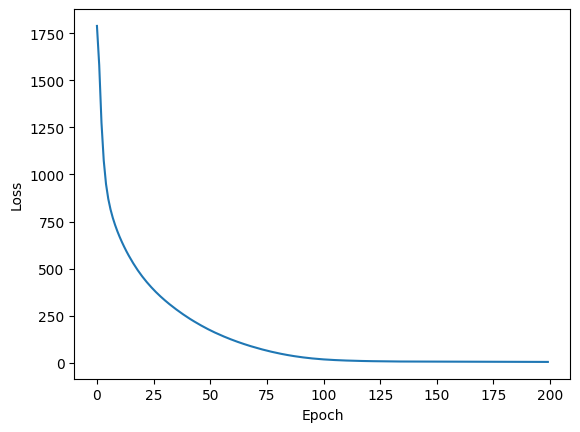

In [ ]:
def MLP_hyper_tuning():
  learning_rate = [1e-5, 3e-5, 5e-5, 8e-5, 1e-4]
  best_accuracy = -math.inf
  best_lr = 0
  epoch = 200
  loss_function = nn.CrossEntropyLoss()
  count = 0
  best_loss_hist = []
  for lr in learning_rate:
    MLP_model,loss_hist = MLP_train(loss_function, X_30_train, Y_30_train, epoch, lr)
    MLP_accuracy = MLP_evaluation(MLP_model, X_30_test, Y_30_test)
    if MLP_accuracy > best_accuracy:
      best_accuracy = MLP_accuracy
      best_lr = lr
      best_loss_hist = loss_hist
    count += 1
    print(f'{count}/5')
    print(f'Best accuracy so far is {best_accuracy}')
  print(f'Best MLP accuracy is {best_accuracy}')
  print(f'Best MLP has a learning rate of {best_lr}')
  plt.plot(best_loss_hist, label="Training Loss History")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()
  plt.close()

MLP_hyper_tuning()

In [ ]:
def LSTM_evaluation(model, input, label):
  # model.eval()
  acc = 0
  for i in range(0, input.shape[0]):
    prediction = model(input[i])
    acc += 1 if torch.argmax(prediction) == torch.argmax(label[i]) else 0
  return acc/(input.shape[0])

1/12
Best accuracy so far: 0.515
2/12
Best accuracy so far: 0.515
3/12
Best accuracy so far: 0.58
4/12
Best accuracy so far: 0.58
5/12
Best accuracy so far: 0.6
6/12
Best accuracy so far: 0.6
7/12
Best accuracy so far: 0.6
8/12
Best accuracy so far: 0.6
9/12
Best accuracy so far: 0.6
10/12
Best accuracy so far: 0.6
11/12
Best accuracy so far: 0.6
12/12
Best accuracy so far: 0.6
Best LSTM Accuracy is 0.6
Best LSTM has a learning rate of 8e-05
Best LSTM has 64 nodes in each hidden layer
Best LSTM has 3 hidden layers


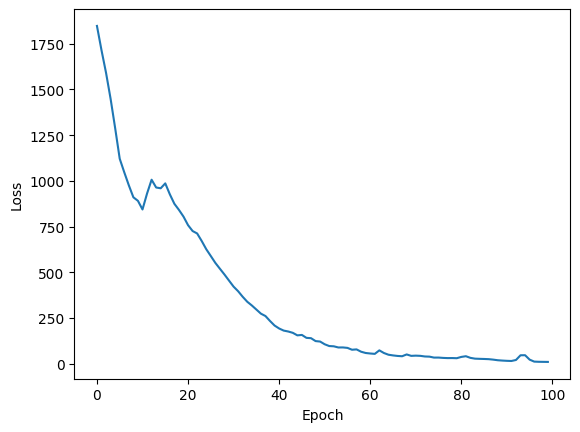

In [ ]:
def LSTM_hyper_tuning():
  learning_rate = [6e-5, 8e-5, 1e-4]
  hidden_layer_size = [64, 128]
  hidden_layer_num = [3, 4]
  best_accuracy = -math.inf
  best_model = {"lr": 0, "hls": 0, "hln": 0}
  best_loss_hist = []
  epoch = 100
  loss_function = nn.CrossEntropyLoss()
  count = 0
  for lr in learning_rate:
    for hls in hidden_layer_size:
      for hln in hidden_layer_num:
        LSTM_model, loss_hist = LSTM_train(loss_function, X_3_train, Y_3_train, epoch, lr, hls, hln)
        LSTM_accuracy = LSTM_evaluation(LSTM_model, X_3_test, Y_3_test)
        if LSTM_accuracy > best_accuracy:
          best_accuracy = LSTM_accuracy
          best_model["lr"] = lr
          best_model["hls"] = hls
          best_model["hln"] = hln
          best_loss_hist = loss_hist
        count += 1
        print(f'{count}/12')
        print(f'Best accuracy so far: {best_accuracy}')
  print(f'Best LSTM Accuracy is {best_accuracy}')
  print(f'Best LSTM has a learning rate of {best_model["lr"]}')
  print(f'Best LSTM has {best_model["hls"]} nodes in each hidden layer')
  print(f'Best LSTM has {best_model["hln"]} hidden layers')
  plt.plot(best_loss_hist, label="Training Loss History")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()
  plt.close()

LSTM_hyper_tuning()
